# Analysis on the Optimizers and selection

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
#!nvidia-smi

In [6]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
# add headings with ##(space) on the markdowns

In [8]:
#!pip install tensorflor keras

In [9]:
import tensorflow as tf
import os

In [10]:
!nvidia-smi

Thu Jun  6 08:51:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   52C    P0              41W / 125W |    720MiB /  6144MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
#! nvidia-smi

In [14]:
#!pip install opencv-python

## Imports

In [15]:
import tensorflow as tf
import os
import cv2
import imghdr

In [16]:
#from google.colab import drive
#drive.mount('/content/drive')

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
#path = '/content/drive/MyDrive/Colab Notebooks/Thesis/data'
#os.chdir(path)

# Load Data

In [19]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

# Split Data

In [20]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [21]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_sample_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Sample'

In [22]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir


'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [23]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [24]:
#train.as_numpy_iterator().next()[0]

In [25]:
#batch[0]

In [27]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 80
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.5
    LAYERS_FINE_TUNE: int   = 8
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9    

# Data Preprocesing- Augmentation

In [28]:
from keras.preprocessing.image import ImageDataGenerator

# with Augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')

# # NO Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255
    )


# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        #target_size=(224, 224),
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        #target_size=(224, 224),
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


# Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten ,Dropout, BatchNormalization
from keras import optimizers
from keras.optimizers import SGD, RMSprop, Adam


from time import perf_counter

In [30]:
SEED = 42 # to always get same dropout and shuffle

In [32]:
def allcnn(optimizer):
    model = Sequential()
    model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))

    model.add(Conv2D(64, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))

    model.add(Conv2D(128, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))

    model.add(Conv2D(128, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5, seed=SEED))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))
    model.add(Dense(1, activation='sigmoid'))

        # load the weights
    # if weights:
    #     model.load_weights(weights)

    model.compile(optimizer = optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


    # return model
    return model

# Checking different optimisation algorithms

Vanilla SGD
SGD with momentum
SGD with Nesterov momentum
RMSProp (default and tuning some parameters)
Adam, AdaGrad, AdaDelta, AdaMax, Nadam and FTRL
We will run all of them in mini-batches of 32 samples and 30 epochs.

Note: I encourage you to change some of the optimisers' parameters below to see how the performance is affected, as well as changing the number of samples and epochs for training.


In [33]:
# I will create a list of optimisers to make the code more concise, and then run them all

# All optimisers will use the same default parameter values, to do a fair comparison:

LEARNING_RATE = 0.01
MOMENTUM = 0.9
RHO = 0.9
EPSILON = 1e-07


vanilla_sgd = optimizers.SGD(
    learning_rate=LEARNING_RATE
)
sgd_momentum = optimizers.SGD(
    learning_rate=LEARNING_RATE, momentum=MOMENTUM
)
sgd_nesterov = optimizers.SGD(
    learning_rate=LEARNING_RATE, momentum=MOMENTUM, nesterov=True
)
rmsprop = optimizers.RMSprop(
    learning_rate=LEARNING_RATE, rho=RHO, momentum=0.0, epsilon=EPSILON, centered=False
)
rmsprop_momentum = optimizers.RMSprop(
    learning_rate=LEARNING_RATE, rho=RHO, momentum=MOMENTUM, epsilon=EPSILON, centered=False
)
adam = optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=EPSILON, amsgrad=False
)
adadelta = optimizers.Adadelta(
    learning_rate=LEARNING_RATE, rho=RHO, epsilon=EPSILON
)
adagrad = optimizers.Adagrad(
    learning_rate=LEARNING_RATE, initial_accumulator_value=0.1, epsilon=EPSILON
)
adamax = optimizers.Adamax(
    learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=EPSILON
)
nadam = optimizers.Nadam(
    learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=EPSILON
)
ftrl = optimizers.Ftrl(
    learning_rate=0.01,
    learning_rate_power=-0.5,
    initial_accumulator_value=0.1,
    l1_regularization_strength=0.0,
    l2_regularization_strength=0.0,
    l2_shrinkage_regularization_strength=0.0,
)


In [34]:
optimisers = [vanilla_sgd, sgd_momentum, sgd_nesterov, rmsprop, rmsprop_momentum, adam, adadelta, adagrad, adamax, nadam, ftrl]

#optimisers = [sgd_momentum, rmsprop, adam]

In [35]:
optimisers_names = [
     'Vanilla SGD', 'SGD Momentum', 'SGD Nesterov', 'RMSprop', 'RMSprop Momentum',
     'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl'
]

#optimisers_names = [
#    'SGD Momentum', 'RMSprop', 'Adam',]

In [36]:
optimisers = {
    name: optimiser for name, optimiser in zip(optimisers_names, optimisers)
}

In [37]:
optimisers

{'Vanilla SGD': <keras.optimizers.optimizer_v2.gradient_descent.SGD at 0x22030e4abe0>,
 'SGD Momentum': <keras.optimizers.optimizer_v2.gradient_descent.SGD at 0x220309f1f10>,
 'SGD Nesterov': <keras.optimizers.optimizer_v2.gradient_descent.SGD at 0x22030ef68e0>,
 'RMSprop': <keras.optimizers.optimizer_v2.rmsprop.RMSprop at 0x22030f1f460>,
 'RMSprop Momentum': <keras.optimizers.optimizer_v2.rmsprop.RMSprop at 0x22030ef6460>,
 'Adam': <keras.optimizers.optimizer_v2.adam.Adam at 0x22030e4a1c0>,
 'Adadelta': <keras.optimizers.optimizer_v2.adadelta.Adadelta at 0x22030ef6790>,
 'Adagrad': <keras.optimizers.optimizer_v2.adagrad.Adagrad at 0x22030ef6ac0>,
 'Adamax': <keras.optimizers.optimizer_v2.adamax.Adamax at 0x22030ef65b0>,
 'Nadam': <keras.optimizers.optimizer_v2.nadam.Nadam at 0x22030ef6e50>,
 'Ftrl': <keras.optimizers.optimizer_v2.ftrl.Ftrl at 0x22030992c40>}

In [59]:
# build model
#model = allcnn(optimiser)

In [60]:
# define hyper parameters
# learning_rateSGD = 0.01
# LEARNING_RATE = 0.001
# weight_decay = 1e-6
# momentum = 0.9
# beta1 = 0.9
# beta2 = 0.999
# epsilon=1e-07
# RHO = 0.9

In [61]:
# sgd = SGD(learning_rate=learning_rateSGD, weight_decay=weight_decay, momentum=momentum, nesterov=True)

# rmsprop = RMSprop(learning_rate=LEARNING_RATE, rho=RHO, momentum=momentum, epsilon=epsilon, centered=False)

# adam = Adam(learning_rate=LEARNING_RATE, beta_1=beta1, beta_2=beta2, epsilon=epsilon)


In [38]:
EPOCHS=40
MINI_BATCH=32
VALIDATION_PERC=0.2
histories = {}

for optimiser_name in optimisers:
    start = perf_counter()
    print('Fitting model with optimiser: ', optimiser_name)
    model = allcnn(optimisers[optimiser_name])
    history = model.fit(train_generator,
                        epochs=EPOCHS,
                        batch_size=MINI_BATCH,
                        validation_data=validation_generator,
                        verbose=0
                       )
    print(' - It took:', round(perf_counter()-start, 2),'seconds')
    histories[optimiser_name] = history.history

Fitting model with optimiser:  Vanilla SGD
 - It took: 1792.69 seconds
Fitting model with optimiser:  SGD Momentum
 - It took: 1759.53 seconds
Fitting model with optimiser:  SGD Nesterov
 - It took: 1763.38 seconds
Fitting model with optimiser:  RMSprop
 - It took: 1832.11 seconds
Fitting model with optimiser:  RMSprop Momentum
 - It took: 1767.67 seconds
Fitting model with optimiser:  Adam
 - It took: 1742.28 seconds
Fitting model with optimiser:  Adadelta
 - It took: 1746.67 seconds
Fitting model with optimiser:  Adagrad
 - It took: 1759.61 seconds
Fitting model with optimiser:  Adamax
 - It took: 1767.33 seconds
Fitting model with optimiser:  Nadam
 - It took: 1901.63 seconds
Fitting model with optimiser:  Ftrl
 - It took: 1762.85 seconds


In [39]:
epochs = range(0, EPOCHS)

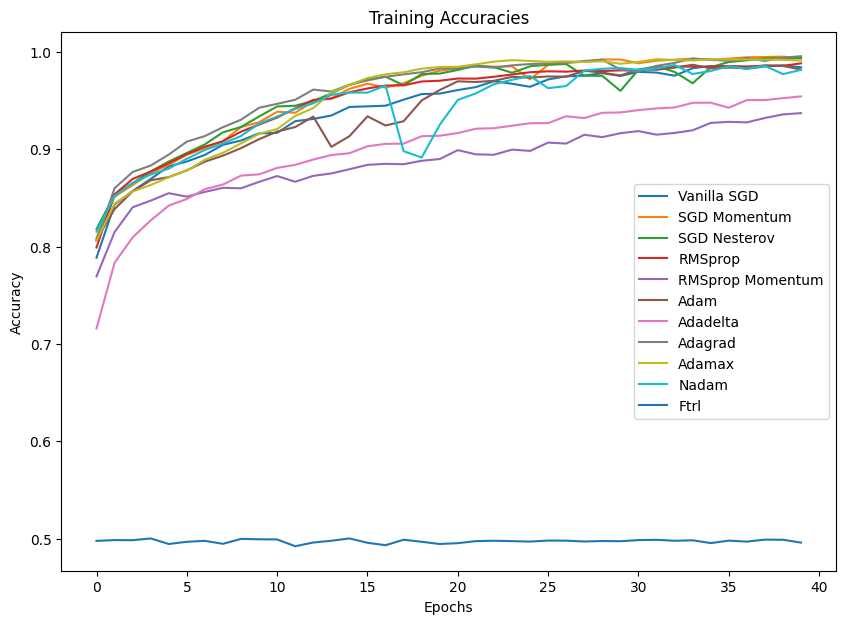

In [40]:
plt.figure(figsize=(10, 7))
for h in histories:
    plt.plot(epochs, histories[h]['accuracy'], label=h)
plt.title(f'Training Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

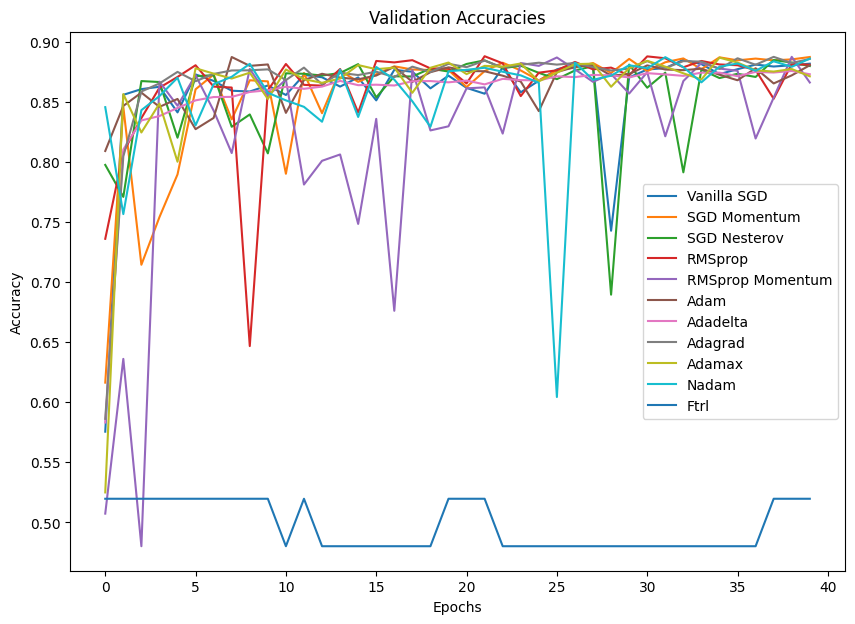

In [41]:
plt.figure(figsize=(10, 7))
for h in histories:
    plt.plot(epochs, histories[h]['val_accuracy'], label=h)
plt.title(f'Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

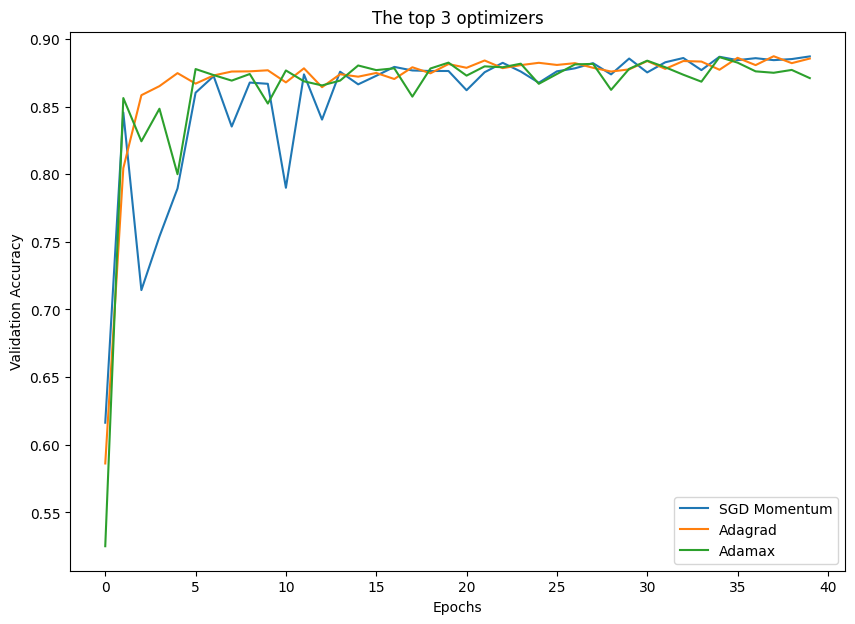

In [45]:
winning_optimisers = [
    'SGD Momentum', 'Adagrad', 'Adamax',
]
plt.figure(figsize=(10, 7))
for h in winning_optimisers:  
    plt.plot(epochs, histories[h]['val_accuracy'], label=h)
plt.title(f'The top 3 optimizers')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

# Train

In [67]:
final_model = allcnn(adagrad)
hist = final_model.fit(train, epochs=30, validation_data=val)

In [68]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_50 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                     

In [69]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 26


In [70]:
fig = plt.figure()
plt.plot(hist.history['loss'][1:], color='teal', label='loss')
plt.plot(hist.history['val_loss'][1:], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [ ]:

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    print(f'Precision: {pre.result()}, Recall:{re.result()}, Accuracy: {acc.result()}')

# Extra Testing on Unseen Data

In [ ]:
import cv2

In [ ]:
Current_dir = os.getcwd()
Current_dir

In [ ]:
#img = cv2.imread('sim.jpg')
#img= cv2.imread(os.path.join('testData','4.png')) # s (246).jpg, 9.png, 4.png, s (481).jpg
img= cv2.imread(os.path.join('unseen data','iframe_221_AD.jpg')) # futurama.jpeg, homer-simpson-wallpaper-preview.jpg , zoid.jpeg, bart-simpson-.jpg, fry.jpeg, homer-simpson-the-simpsons-.jpg, marg.jpg
#img

In [ ]:
len(img)


In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
#plt.imshow(resize.numpy().astype(int))
#plt.show()

In [ ]:
resize.shape

In [ ]:
np.expand_dims(resize,0).shape

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

simple image = 1 <br>
Ad = 0

In [ ]:
#class 1= simple img, class 0 = Ad

if yhat > 0.5:
    print(f'Predicted Simple Image')
else:
    print(f'Predicted Ad')

# Saving the model

In [ ]:
from keras.models import load_model

In [ ]:
#model.save(os.path.join('models','ad_classifier_first.h5'))
model.summary()